# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [25]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

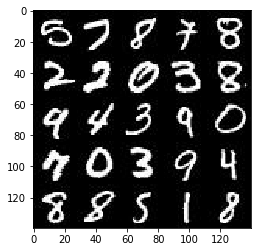

In [26]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import matplotlib
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

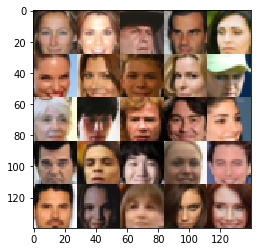

In [27]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [29]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='real_inputs')
    z_inputs = tf.placeholder(tf.float32,shape=(None,z_dim),name='z_inputs')
    lr = tf.placeholder(tf.float32,name='learning_rate')

    return real_inputs,z_inputs,lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [30]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha=0.1
        
        h1 = tf.layers.conv2d(images,64,5,2,'same')
        h1 = tf.maximum(h1,h1*alpha)
        
        h2 = tf.layers.conv2d(h1,128,5,2,'same')
        h2 = tf.layers.batch_normalization(h2,training=True)
        h2 = tf.maximum(h2,h2*alpha)
        
        h3 = tf.layers.conv2d(h2,256,5,2,'same')
        h3 = tf.layers.batch_normalization(h3,training=True)
        h3 = tf.maximum(h3,h3*alpha)
        
        flat = tf.reshape(h3,(-1,4*4*256))
        logits = tf.layers.dense(flat, 1)
        
        logits = tf.layers.dropout(logits, rate=0.5)
        out = tf.sigmoid(logits)

    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not(is_train)):
        alpha = 0.1
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))

    d_loss = d_loss_real + d_loss_fake


    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt,g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_width, img_height, img_channels = data_shape
    real_input, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    losses=[]
    n_images=25
    print_every = 10
    show_every = 100
    step=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images*=2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                step+=1
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input: batch_images,z_input: batch_z, lr:learning_rate})
                
                train_loss_d = sess.run(d_loss, {z_input: batch_z, real_input: batch_images})
                train_loss_g = g_loss.eval({z_input: batch_z})
                if step%print_every==0:
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                
                
                    #show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                if step%show_every==0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                losses.append((train_loss_d, train_loss_g))
                        
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2752... Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 2.7032... Generator Loss: 0.1110
Epoch 1/2... Discriminator Loss: 1.6245... Generator Loss: 0.3874
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 6.7410
Epoch 1/2... Discriminator Loss: 0.4907... Generator Loss: 3.7147
Epoch 1/2... Discriminator Loss: 2.1985... Generator Loss: 0.1921
Epoch 1/2... Discriminator Loss: 0.8597... Generator Loss: 6.0120
Epoch 1/2... Discriminator Loss: 0.5875... Generator Loss: 1.8112
Epoch 1/2... Discriminator Loss: 0.5094... Generator Loss: 2.2989
Epoch 1/2... Discriminator Loss: 0.6237... Generator Loss: 1.5703


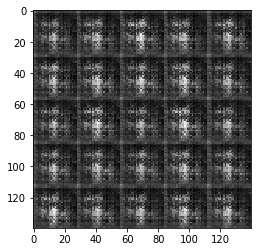

Epoch 1/2... Discriminator Loss: 0.4744... Generator Loss: 2.8598
Epoch 1/2... Discriminator Loss: 0.5054... Generator Loss: 2.4319
Epoch 1/2... Discriminator Loss: 0.4278... Generator Loss: 3.3023
Epoch 1/2... Discriminator Loss: 1.0428... Generator Loss: 8.3503
Epoch 1/2... Discriminator Loss: 0.5276... Generator Loss: 2.1188
Epoch 1/2... Discriminator Loss: 0.4971... Generator Loss: 2.4244
Epoch 1/2... Discriminator Loss: 0.6247... Generator Loss: 2.3161
Epoch 1/2... Discriminator Loss: 0.5839... Generator Loss: 3.6313
Epoch 1/2... Discriminator Loss: 0.4977... Generator Loss: 2.4932
Epoch 1/2... Discriminator Loss: 0.4498... Generator Loss: 3.4574


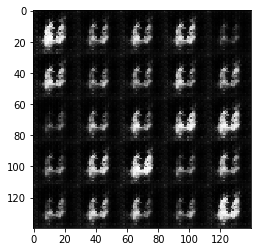

Epoch 1/2... Discriminator Loss: 0.4142... Generator Loss: 3.5331
Epoch 1/2... Discriminator Loss: 0.4350... Generator Loss: 2.9412
Epoch 1/2... Discriminator Loss: 0.4933... Generator Loss: 2.7071
Epoch 1/2... Discriminator Loss: 0.5333... Generator Loss: 3.2392
Epoch 1/2... Discriminator Loss: 0.4519... Generator Loss: 2.7140
Epoch 1/2... Discriminator Loss: 0.5088... Generator Loss: 2.6370
Epoch 1/2... Discriminator Loss: 0.4945... Generator Loss: 2.2390
Epoch 1/2... Discriminator Loss: 0.4397... Generator Loss: 2.8741
Epoch 1/2... Discriminator Loss: 0.4660... Generator Loss: 3.1385
Epoch 1/2... Discriminator Loss: 0.4465... Generator Loss: 2.8288


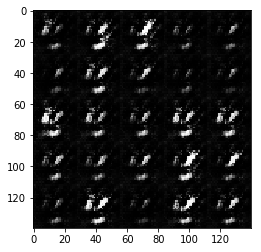

Epoch 1/2... Discriminator Loss: 0.5377... Generator Loss: 3.5622
Epoch 1/2... Discriminator Loss: 0.5157... Generator Loss: 2.1074
Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 0.9183
Epoch 1/2... Discriminator Loss: 0.5205... Generator Loss: 3.2474
Epoch 1/2... Discriminator Loss: 1.1160... Generator Loss: 1.3958
Epoch 1/2... Discriminator Loss: 0.6923... Generator Loss: 1.6188
Epoch 1/2... Discriminator Loss: 0.6283... Generator Loss: 2.0327
Epoch 1/2... Discriminator Loss: 0.6292... Generator Loss: 4.5973
Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 1.9560
Epoch 1/2... Discriminator Loss: 0.7987... Generator Loss: 3.4796


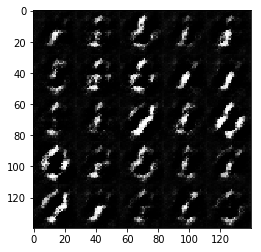

Epoch 1/2... Discriminator Loss: 0.7694... Generator Loss: 1.3294
Epoch 1/2... Discriminator Loss: 0.9588... Generator Loss: 0.9258
Epoch 1/2... Discriminator Loss: 0.8613... Generator Loss: 1.1716
Epoch 1/2... Discriminator Loss: 0.7083... Generator Loss: 1.7201
Epoch 1/2... Discriminator Loss: 0.7709... Generator Loss: 1.6370
Epoch 1/2... Discriminator Loss: 0.5990... Generator Loss: 3.0101
Epoch 1/2... Discriminator Loss: 0.6445... Generator Loss: 1.8648
Epoch 1/2... Discriminator Loss: 0.5693... Generator Loss: 2.3376
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 1.3260
Epoch 1/2... Discriminator Loss: 0.7876... Generator Loss: 2.3213


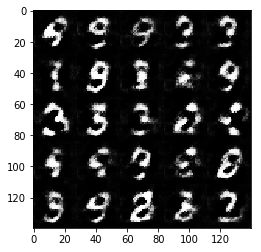

Epoch 1/2... Discriminator Loss: 0.8135... Generator Loss: 1.2165
Epoch 1/2... Discriminator Loss: 0.6365... Generator Loss: 1.9438
Epoch 1/2... Discriminator Loss: 0.8635... Generator Loss: 1.2310
Epoch 1/2... Discriminator Loss: 0.8768... Generator Loss: 1.1388
Epoch 1/2... Discriminator Loss: 0.6675... Generator Loss: 1.6157
Epoch 1/2... Discriminator Loss: 0.7060... Generator Loss: 3.4495
Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 0.7953
Epoch 1/2... Discriminator Loss: 0.8290... Generator Loss: 2.1239
Epoch 1/2... Discriminator Loss: 0.9273... Generator Loss: 0.9776
Epoch 1/2... Discriminator Loss: 0.7854... Generator Loss: 1.3714


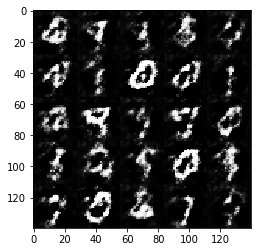

Epoch 1/2... Discriminator Loss: 0.9273... Generator Loss: 1.3873
Epoch 1/2... Discriminator Loss: 1.4440... Generator Loss: 0.5581
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.7577
Epoch 1/2... Discriminator Loss: 0.7411... Generator Loss: 1.8391
Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 0.7667... Generator Loss: 1.6544
Epoch 1/2... Discriminator Loss: 0.7859... Generator Loss: 1.2317
Epoch 1/2... Discriminator Loss: 1.6010... Generator Loss: 0.4453
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 1.2882
Epoch 1/2... Discriminator Loss: 0.9194... Generator Loss: 1.5613


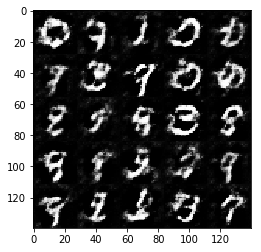

Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 0.8880
Epoch 1/2... Discriminator Loss: 1.8045... Generator Loss: 0.3276
Epoch 1/2... Discriminator Loss: 1.0377... Generator Loss: 1.1272
Epoch 1/2... Discriminator Loss: 0.7182... Generator Loss: 1.7277
Epoch 1/2... Discriminator Loss: 1.5005... Generator Loss: 0.4277
Epoch 1/2... Discriminator Loss: 0.9566... Generator Loss: 0.9979
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 0.8150
Epoch 1/2... Discriminator Loss: 1.6685... Generator Loss: 0.3545
Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 1.1495
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 1.3180


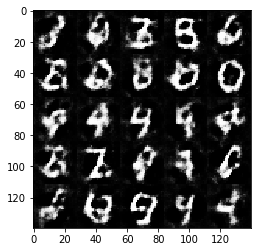

Epoch 1/2... Discriminator Loss: 0.9012... Generator Loss: 1.2481
Epoch 1/2... Discriminator Loss: 1.3183... Generator Loss: 0.5334
Epoch 1/2... Discriminator Loss: 0.9764... Generator Loss: 1.7608
Epoch 1/2... Discriminator Loss: 1.0651... Generator Loss: 0.8129
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 1.6503
Epoch 1/2... Discriminator Loss: 1.0172... Generator Loss: 0.8577
Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 2.0141
Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 1.5899
Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.6212
Epoch 1/2... Discriminator Loss: 1.2914... Generator Loss: 0.5591


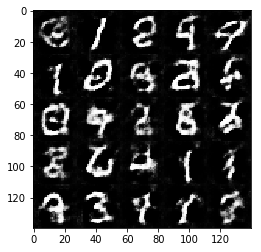

Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 0.7313
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.6855
Epoch 1/2... Discriminator Loss: 1.4397... Generator Loss: 0.4925
Epoch 1/2... Discriminator Loss: 1.1999... Generator Loss: 0.6510
Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 1.1539
Epoch 1/2... Discriminator Loss: 0.9812... Generator Loss: 0.9219
Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 0.5467
Epoch 1/2... Discriminator Loss: 0.8352... Generator Loss: 1.4572
Epoch 1/2... Discriminator Loss: 1.6222... Generator Loss: 0.3592


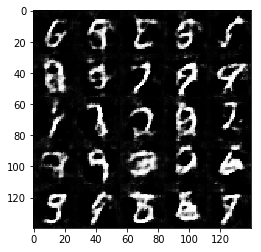

Epoch 1/2... Discriminator Loss: 1.1838... Generator Loss: 0.7004
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.5486
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.4931
Epoch 1/2... Discriminator Loss: 1.1682... Generator Loss: 0.6637
Epoch 1/2... Discriminator Loss: 0.9743... Generator Loss: 0.9645
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 0.5476
Epoch 1/2... Discriminator Loss: 0.8887... Generator Loss: 1.1078
Epoch 1/2... Discriminator Loss: 1.0404... Generator Loss: 0.9099
Epoch 1/2... Discriminator Loss: 1.0140... Generator Loss: 1.0069
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 1.7530


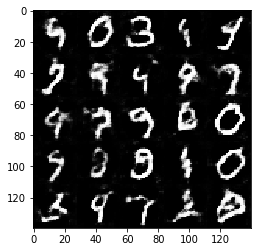

Epoch 1/2... Discriminator Loss: 0.9807... Generator Loss: 0.9801
Epoch 1/2... Discriminator Loss: 0.9538... Generator Loss: 1.0182
Epoch 1/2... Discriminator Loss: 1.1190... Generator Loss: 0.7252
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 1.6083
Epoch 1/2... Discriminator Loss: 1.4303... Generator Loss: 0.5077
Epoch 1/2... Discriminator Loss: 1.0318... Generator Loss: 0.9208
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 1.0893
Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 1.2659


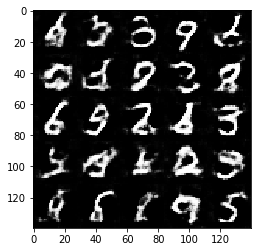

Epoch 1/2... Discriminator Loss: 1.0758... Generator Loss: 1.3523
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 0.8497
Epoch 1/2... Discriminator Loss: 1.5062... Generator Loss: 0.4223
Epoch 1/2... Discriminator Loss: 0.9203... Generator Loss: 1.3138
Epoch 1/2... Discriminator Loss: 0.8753... Generator Loss: 1.3356
Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 0.9404
Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 1.1003
Epoch 1/2... Discriminator Loss: 1.4424... Generator Loss: 0.4867
Epoch 1/2... Discriminator Loss: 0.9157... Generator Loss: 1.0184


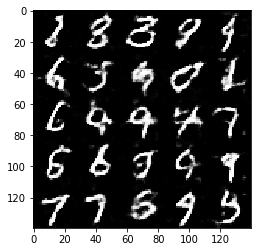

Epoch 1/2... Discriminator Loss: 1.4689... Generator Loss: 0.4686
Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 0.8425
Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 1.0453
Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.5362
Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 1.1963
Epoch 1/2... Discriminator Loss: 1.3704... Generator Loss: 0.5525
Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 1.6281
Epoch 1/2... Discriminator Loss: 1.0120... Generator Loss: 1.2941
Epoch 1/2... Discriminator Loss: 0.9923... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 0.9138... Generator Loss: 1.1381


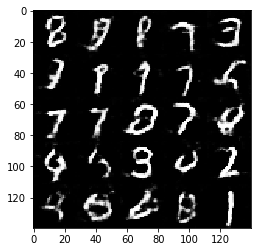

Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 1.7504
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 0.9501
Epoch 1/2... Discriminator Loss: 1.4007... Generator Loss: 0.5104
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 1.5402
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 1.6603
Epoch 1/2... Discriminator Loss: 1.0862... Generator Loss: 1.7883
Epoch 1/2... Discriminator Loss: 1.0786... Generator Loss: 0.7984
Epoch 1/2... Discriminator Loss: 1.5131... Generator Loss: 0.4740
Epoch 1/2... Discriminator Loss: 1.0392... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 0.9384... Generator Loss: 1.3782


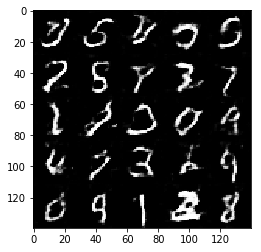

Epoch 1/2... Discriminator Loss: 0.9585... Generator Loss: 1.0803
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.4666
Epoch 1/2... Discriminator Loss: 0.9557... Generator Loss: 1.0437
Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 1.0401
Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 1.1390... Generator Loss: 2.4303
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 0.7599
Epoch 1/2... Discriminator Loss: 0.8489... Generator Loss: 1.5632
Epoch 1/2... Discriminator Loss: 1.0279... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 1.6814... Generator Loss: 0.3817


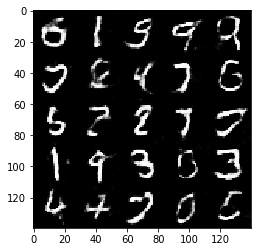

Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 1.2148
Epoch 1/2... Discriminator Loss: 0.9352... Generator Loss: 0.9494
Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.5907
Epoch 1/2... Discriminator Loss: 1.0311... Generator Loss: 1.7031
Epoch 1/2... Discriminator Loss: 2.2228... Generator Loss: 0.2657
Epoch 1/2... Discriminator Loss: 0.9447... Generator Loss: 0.9406
Epoch 1/2... Discriminator Loss: 0.7503... Generator Loss: 1.7058
Epoch 1/2... Discriminator Loss: 0.8149... Generator Loss: 1.5095
Epoch 1/2... Discriminator Loss: 0.8331... Generator Loss: 1.4927
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.5016


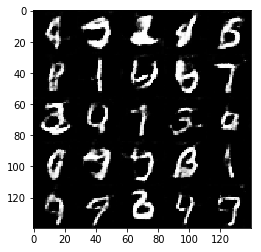

Epoch 1/2... Discriminator Loss: 0.8985... Generator Loss: 1.0160
Epoch 1/2... Discriminator Loss: 2.4456... Generator Loss: 4.0787
Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 0.7317
Epoch 1/2... Discriminator Loss: 1.1763... Generator Loss: 0.6802
Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 1.3657
Epoch 1/2... Discriminator Loss: 1.0762... Generator Loss: 0.7313
Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 1.5507
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 2.4640
Epoch 1/2... Discriminator Loss: 1.1796... Generator Loss: 0.7090
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 0.6757


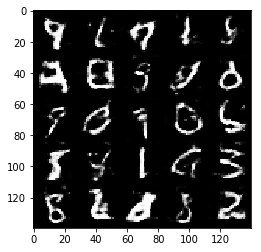

Epoch 1/2... Discriminator Loss: 1.6994... Generator Loss: 0.3528
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 1.0851
Epoch 1/2... Discriminator Loss: 1.0211... Generator Loss: 0.8340
Epoch 1/2... Discriminator Loss: 1.6482... Generator Loss: 0.3749
Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 1.2881
Epoch 1/2... Discriminator Loss: 1.0063... Generator Loss: 0.8594
Epoch 1/2... Discriminator Loss: 0.9308... Generator Loss: 1.0790
Epoch 2/2... Discriminator Loss: 0.9238... Generator Loss: 1.4180
Epoch 2/2... Discriminator Loss: 0.9100... Generator Loss: 1.6809
Epoch 2/2... Discriminator Loss: 1.0215... Generator Loss: 1.0632


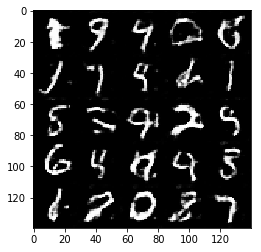

Epoch 2/2... Discriminator Loss: 0.9428... Generator Loss: 0.9777
Epoch 2/2... Discriminator Loss: 2.5030... Generator Loss: 0.1648
Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 1.0751
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 1.1483... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.2686... Generator Loss: 0.5484
Epoch 2/2... Discriminator Loss: 1.7546... Generator Loss: 0.3288
Epoch 2/2... Discriminator Loss: 1.2408... Generator Loss: 0.6028
Epoch 2/2... Discriminator Loss: 0.9880... Generator Loss: 0.8638
Epoch 2/2... Discriminator Loss: 2.0242... Generator Loss: 0.3327


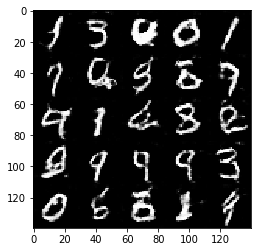

Epoch 2/2... Discriminator Loss: 1.4286... Generator Loss: 0.5097
Epoch 2/2... Discriminator Loss: 0.8213... Generator Loss: 1.1306
Epoch 2/2... Discriminator Loss: 1.2469... Generator Loss: 0.6042
Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 0.9740
Epoch 2/2... Discriminator Loss: 1.1837... Generator Loss: 0.6692
Epoch 2/2... Discriminator Loss: 1.8955... Generator Loss: 0.2912
Epoch 2/2... Discriminator Loss: 0.8723... Generator Loss: 1.3409
Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 1.3943
Epoch 2/2... Discriminator Loss: 1.0071... Generator Loss: 0.8440
Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 1.0482


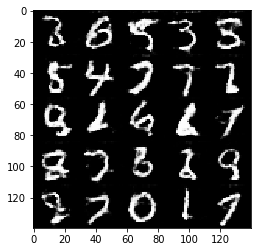

Epoch 2/2... Discriminator Loss: 0.8323... Generator Loss: 1.0964
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 1.6149
Epoch 2/2... Discriminator Loss: 1.1433... Generator Loss: 0.7022
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 1.0394
Epoch 2/2... Discriminator Loss: 1.1665... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 0.9240... Generator Loss: 1.0368
Epoch 2/2... Discriminator Loss: 1.3609... Generator Loss: 2.2625
Epoch 2/2... Discriminator Loss: 1.3273... Generator Loss: 1.9147
Epoch 2/2... Discriminator Loss: 0.9903... Generator Loss: 0.9071
Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 0.7631


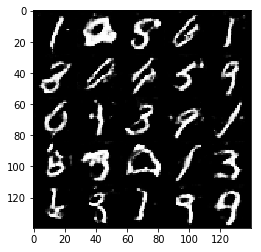

Epoch 2/2... Discriminator Loss: 0.7954... Generator Loss: 1.1688
Epoch 2/2... Discriminator Loss: 0.7974... Generator Loss: 1.2908
Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 1.1829
Epoch 2/2... Discriminator Loss: 1.0111... Generator Loss: 0.8268
Epoch 2/2... Discriminator Loss: 0.8409... Generator Loss: 1.1995
Epoch 2/2... Discriminator Loss: 0.8357... Generator Loss: 1.1098
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 0.5907
Epoch 2/2... Discriminator Loss: 0.9071... Generator Loss: 1.6952
Epoch 2/2... Discriminator Loss: 1.0238... Generator Loss: 0.9789
Epoch 2/2... Discriminator Loss: 1.2564... Generator Loss: 0.5911


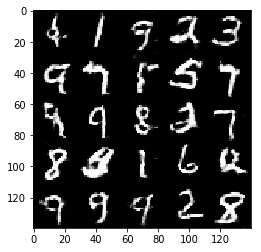

Epoch 2/2... Discriminator Loss: 0.8257... Generator Loss: 1.2367
Epoch 2/2... Discriminator Loss: 1.0321... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.6269... Generator Loss: 0.3977
Epoch 2/2... Discriminator Loss: 1.0159... Generator Loss: 0.8231
Epoch 2/2... Discriminator Loss: 0.9288... Generator Loss: 1.5444
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.6658
Epoch 2/2... Discriminator Loss: 1.2647... Generator Loss: 0.6274
Epoch 2/2... Discriminator Loss: 0.9377... Generator Loss: 0.9908
Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 0.9932... Generator Loss: 0.9765


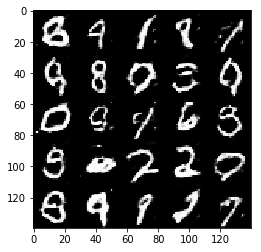

Epoch 2/2... Discriminator Loss: 1.7219... Generator Loss: 3.3410
Epoch 2/2... Discriminator Loss: 0.9469... Generator Loss: 1.1658
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 1.1566
Epoch 2/2... Discriminator Loss: 0.8343... Generator Loss: 1.1154
Epoch 2/2... Discriminator Loss: 0.8425... Generator Loss: 1.1773
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 1.2856
Epoch 2/2... Discriminator Loss: 1.0516... Generator Loss: 0.9093
Epoch 2/2... Discriminator Loss: 0.7822... Generator Loss: 1.6999
Epoch 2/2... Discriminator Loss: 1.0915... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 0.7293... Generator Loss: 1.3605


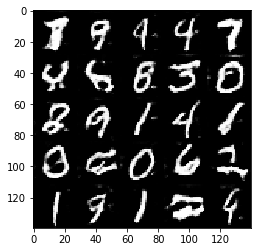

Epoch 2/2... Discriminator Loss: 1.1502... Generator Loss: 0.6511
Epoch 2/2... Discriminator Loss: 1.9534... Generator Loss: 0.3203
Epoch 2/2... Discriminator Loss: 1.2610... Generator Loss: 0.6285
Epoch 2/2... Discriminator Loss: 0.7913... Generator Loss: 1.2204
Epoch 2/2... Discriminator Loss: 0.7426... Generator Loss: 1.3642
Epoch 2/2... Discriminator Loss: 1.0192... Generator Loss: 1.8881
Epoch 2/2... Discriminator Loss: 1.0294... Generator Loss: 0.9270
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 0.9442
Epoch 2/2... Discriminator Loss: 1.0622... Generator Loss: 1.8424
Epoch 2/2... Discriminator Loss: 0.8267... Generator Loss: 1.1550


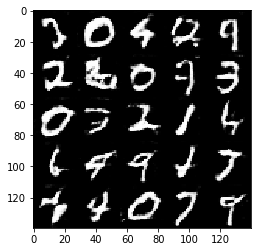

Epoch 2/2... Discriminator Loss: 0.6848... Generator Loss: 1.9207
Epoch 2/2... Discriminator Loss: 0.8524... Generator Loss: 1.2458
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 1.2937
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 0.8841
Epoch 2/2... Discriminator Loss: 3.3751... Generator Loss: 0.1292
Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 0.7882
Epoch 2/2... Discriminator Loss: 0.9525... Generator Loss: 0.9136
Epoch 2/2... Discriminator Loss: 1.3041... Generator Loss: 0.5411
Epoch 2/2... Discriminator Loss: 0.8950... Generator Loss: 2.0829
Epoch 2/2... Discriminator Loss: 1.1784... Generator Loss: 0.7334


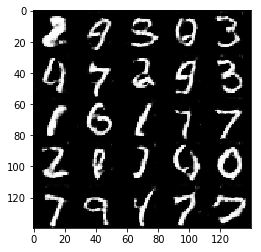

Epoch 2/2... Discriminator Loss: 0.8020... Generator Loss: 1.1601
Epoch 2/2... Discriminator Loss: 0.7667... Generator Loss: 1.2544
Epoch 2/2... Discriminator Loss: 1.1247... Generator Loss: 0.7298
Epoch 2/2... Discriminator Loss: 0.7238... Generator Loss: 1.6041
Epoch 2/2... Discriminator Loss: 2.0410... Generator Loss: 0.3290
Epoch 2/2... Discriminator Loss: 0.8555... Generator Loss: 2.0216
Epoch 2/2... Discriminator Loss: 2.6004... Generator Loss: 0.1809
Epoch 2/2... Discriminator Loss: 0.7344... Generator Loss: 1.7329
Epoch 2/2... Discriminator Loss: 0.9290... Generator Loss: 0.9528
Epoch 2/2... Discriminator Loss: 1.0531... Generator Loss: 0.7941


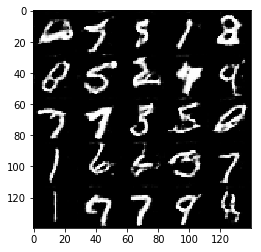

Epoch 2/2... Discriminator Loss: 0.8716... Generator Loss: 1.0737
Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 1.5981
Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 0.6313
Epoch 2/2... Discriminator Loss: 1.3258... Generator Loss: 0.6087
Epoch 2/2... Discriminator Loss: 0.6925... Generator Loss: 1.6394
Epoch 2/2... Discriminator Loss: 0.7381... Generator Loss: 1.8320
Epoch 2/2... Discriminator Loss: 0.8757... Generator Loss: 1.0297
Epoch 2/2... Discriminator Loss: 0.8195... Generator Loss: 1.1490
Epoch 2/2... Discriminator Loss: 0.6913... Generator Loss: 1.4714
Epoch 2/2... Discriminator Loss: 0.8762... Generator Loss: 1.0186


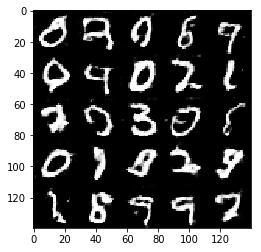

Epoch 2/2... Discriminator Loss: 1.7397... Generator Loss: 0.4263
Epoch 2/2... Discriminator Loss: 0.6474... Generator Loss: 2.0066
Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 1.3453
Epoch 2/2... Discriminator Loss: 0.7984... Generator Loss: 2.1663
Epoch 2/2... Discriminator Loss: 0.7267... Generator Loss: 1.4094
Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 0.9286
Epoch 2/2... Discriminator Loss: 1.5280... Generator Loss: 0.4503
Epoch 2/2... Discriminator Loss: 0.7606... Generator Loss: 1.5403
Epoch 2/2... Discriminator Loss: 0.7757... Generator Loss: 1.4191
Epoch 2/2... Discriminator Loss: 1.6281... Generator Loss: 2.7872


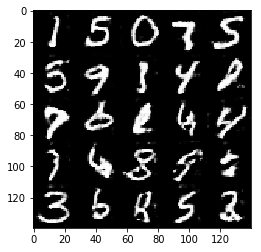

Epoch 2/2... Discriminator Loss: 1.1879... Generator Loss: 0.7794
Epoch 2/2... Discriminator Loss: 1.1403... Generator Loss: 0.7113
Epoch 2/2... Discriminator Loss: 0.7187... Generator Loss: 1.4461
Epoch 2/2... Discriminator Loss: 0.7930... Generator Loss: 1.1824
Epoch 2/2... Discriminator Loss: 0.8568... Generator Loss: 1.0897
Epoch 2/2... Discriminator Loss: 0.7551... Generator Loss: 1.2847
Epoch 2/2... Discriminator Loss: 0.7557... Generator Loss: 1.3301
Epoch 2/2... Discriminator Loss: 1.0486... Generator Loss: 0.9523
Epoch 2/2... Discriminator Loss: 0.6857... Generator Loss: 1.4606
Epoch 2/2... Discriminator Loss: 1.0044... Generator Loss: 0.8901


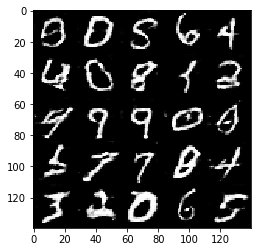

Epoch 2/2... Discriminator Loss: 0.8368... Generator Loss: 2.2810
Epoch 2/2... Discriminator Loss: 1.5743... Generator Loss: 0.4574
Epoch 2/2... Discriminator Loss: 1.0049... Generator Loss: 1.0411
Epoch 2/2... Discriminator Loss: 0.8301... Generator Loss: 1.2479
Epoch 2/2... Discriminator Loss: 1.9908... Generator Loss: 0.2646
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 1.0519
Epoch 2/2... Discriminator Loss: 0.7233... Generator Loss: 1.2986
Epoch 2/2... Discriminator Loss: 0.7936... Generator Loss: 1.1707
Epoch 2/2... Discriminator Loss: 0.7192... Generator Loss: 1.4827
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 1.9082


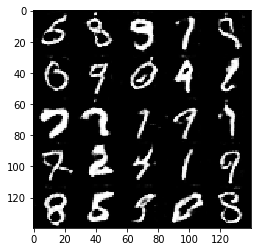

Epoch 2/2... Discriminator Loss: 1.0026... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 0.6272... Generator Loss: 1.6728
Epoch 2/2... Discriminator Loss: 1.8144... Generator Loss: 2.9659
Epoch 2/2... Discriminator Loss: 1.0217... Generator Loss: 0.8967
Epoch 2/2... Discriminator Loss: 0.9730... Generator Loss: 2.2608
Epoch 2/2... Discriminator Loss: 0.6998... Generator Loss: 1.5240
Epoch 2/2... Discriminator Loss: 0.6851... Generator Loss: 1.4452
Epoch 2/2... Discriminator Loss: 1.4706... Generator Loss: 0.5871
Epoch 2/2... Discriminator Loss: 0.8438... Generator Loss: 1.1578
Epoch 2/2... Discriminator Loss: 0.8249... Generator Loss: 1.1655


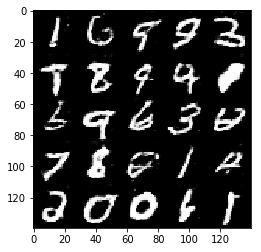

Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 1.5179
Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.5824
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 0.8661
Epoch 2/2... Discriminator Loss: 0.7080... Generator Loss: 1.3728
Epoch 2/2... Discriminator Loss: 0.7984... Generator Loss: 1.2447
Epoch 2/2... Discriminator Loss: 0.7750... Generator Loss: 1.1829
Epoch 2/2... Discriminator Loss: 0.8380... Generator Loss: 1.0654
Epoch 2/2... Discriminator Loss: 1.2706... Generator Loss: 0.6665
Epoch 2/2... Discriminator Loss: 0.7930... Generator Loss: 1.1495
Epoch 2/2... Discriminator Loss: 0.6852... Generator Loss: 1.9991


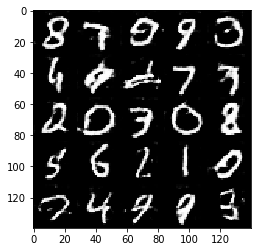

Epoch 2/2... Discriminator Loss: 1.4027... Generator Loss: 0.5185
Epoch 2/2... Discriminator Loss: 0.6539... Generator Loss: 1.7609
Epoch 2/2... Discriminator Loss: 0.7950... Generator Loss: 1.6443
Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 0.9917
Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 1.4301
Epoch 2/2... Discriminator Loss: 0.8582... Generator Loss: 1.0278
Epoch 2/2... Discriminator Loss: 0.7195... Generator Loss: 1.6915
Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 0.5324
Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 0.7842
Epoch 2/2... Discriminator Loss: 0.7547... Generator Loss: 1.2943


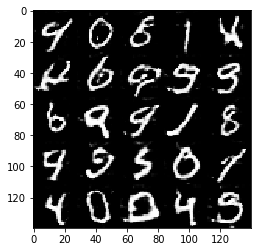

Epoch 2/2... Discriminator Loss: 0.9935... Generator Loss: 0.9112
Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 1.3962
Epoch 2/2... Discriminator Loss: 1.0311... Generator Loss: 0.8315
Epoch 2/2... Discriminator Loss: 0.9780... Generator Loss: 0.9453
Epoch 2/2... Discriminator Loss: 0.8119... Generator Loss: 1.7479
Epoch 2/2... Discriminator Loss: 2.4255... Generator Loss: 0.2726
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 1.1749
Epoch 2/2... Discriminator Loss: 0.5989... Generator Loss: 1.6956
Epoch 2/2... Discriminator Loss: 0.9032... Generator Loss: 0.8932
Epoch 2/2... Discriminator Loss: 0.8632... Generator Loss: 1.0722


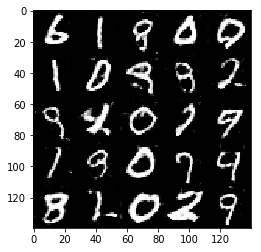

Epoch 2/2... Discriminator Loss: 0.7755... Generator Loss: 1.2073
Epoch 2/2... Discriminator Loss: 1.0595... Generator Loss: 0.8119
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 1.0072
Epoch 2/2... Discriminator Loss: 0.7190... Generator Loss: 1.3338
Epoch 2/2... Discriminator Loss: 1.5565... Generator Loss: 0.5430
Epoch 2/2... Discriminator Loss: 0.9590... Generator Loss: 0.9957
Epoch 2/2... Discriminator Loss: 0.7811... Generator Loss: 1.2211
Epoch 2/2... Discriminator Loss: 0.6870... Generator Loss: 1.4312
Epoch 2/2... Discriminator Loss: 0.6832... Generator Loss: 1.7527
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 1.0461


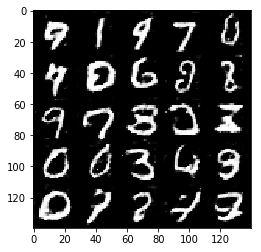

Epoch 2/2... Discriminator Loss: 0.9379... Generator Loss: 2.7396
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 1.7417... Generator Loss: 0.3932
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 0.6086
Epoch 2/2... Discriminator Loss: 0.6712... Generator Loss: 1.4782


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.7590
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 6.0548
Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 3.7214
Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 2.0844
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 0.7280... Generator Loss: 1.8433
Epoch 1/1... Discriminator Loss: 0.6223... Generator Loss: 4.3887
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 3.7747
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 3.4912


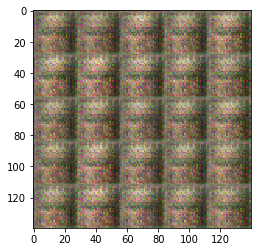

Epoch 1/1... Discriminator Loss: 0.5280... Generator Loss: 2.6786
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 2.6209
Epoch 1/1... Discriminator Loss: 0.5689... Generator Loss: 1.9490
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 2.3988
Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 1.9946
Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 2.8450
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.6371
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.7765
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.9408


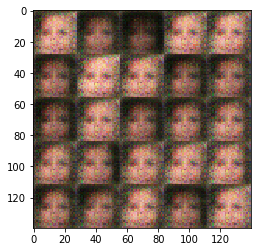

Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 2.5680
Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 2.3480
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.5320
Epoch 1/1... Discriminator Loss: 0.6917... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.4127
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.0953


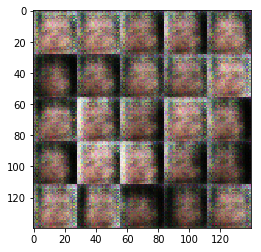

Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 2.2785
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 1.4667
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 2.2221
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.6252
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 2.9148
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 2.1487
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.7902


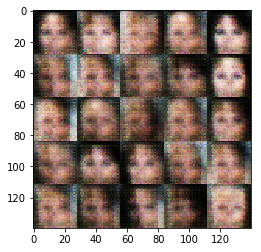

Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 2.3779
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 1.1292
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 1.1599
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.2272
Epoch 1/1... Discriminator Loss: 1.8869... Generator Loss: 2.0442
Epoch 1/1... Discriminator Loss: 1.7279... Generator Loss: 0.3641
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 2.7734


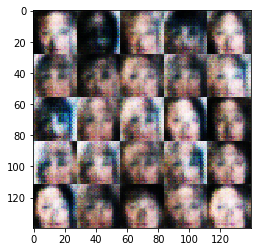

Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.3608
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 1.7299
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.4231
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.7762... Generator Loss: 0.3149
Epoch 1/1... Discriminator Loss: 1.6110... Generator Loss: 0.4422


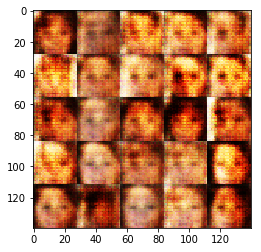

Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 2.6695
Epoch 1/1... Discriminator Loss: 0.8385... Generator Loss: 1.4185
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 1.1469
Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 1.7903
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.7942


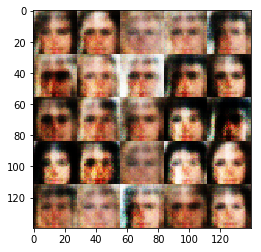

Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 1.2858
Epoch 1/1... Discriminator Loss: 1.5952... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 2.0654
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 1.2187
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.4397
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.1128
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 2.4570


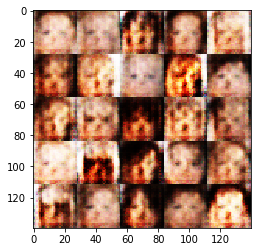

Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 1.3737
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.6101... Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 1.0073


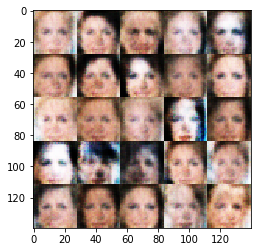

Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.2550
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 1.4806
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.8233
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 1.8126


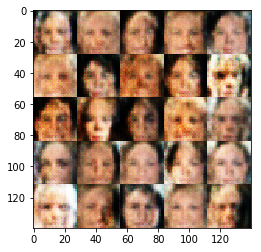

Epoch 1/1... Discriminator Loss: 0.8115... Generator Loss: 1.3860
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 1.9312
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 1.4380
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.2501
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.3704
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 1.1752
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.6219
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.3061


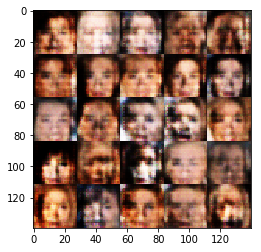

Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 1.4255
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 1.1994
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 2.5212
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 1.6916
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 1.5236
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 0.6847... Generator Loss: 1.6908
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 1.2102


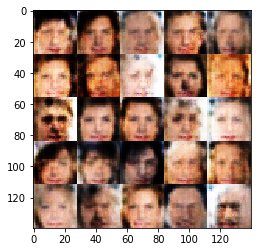

Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.4392
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 2.0448
Epoch 1/1... Discriminator Loss: 1.6109... Generator Loss: 0.3671
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.4267
Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 1.5406
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 2.7637
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 1.1673


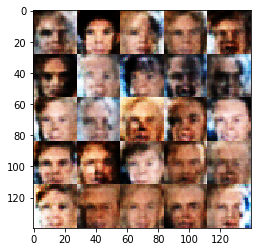

Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 2.8489
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 1.1499
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.1379
Epoch 1/1... Discriminator Loss: 2.3991... Generator Loss: 0.1741
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 2.7497
Epoch 1/1... Discriminator Loss: 0.7600... Generator Loss: 2.7177
Epoch 1/1... Discriminator Loss: 0.7544... Generator Loss: 1.7522
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 2.2139
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.5172


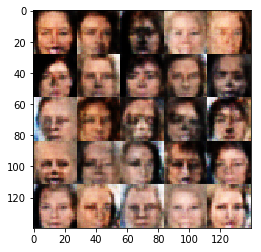

Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 1.9704
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 1.7287


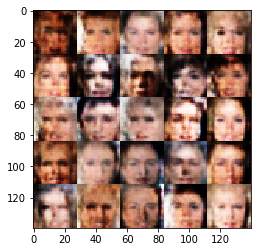

Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 1.8473
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.1003
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 1.8721
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 2.5632
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 1.9816
Epoch 1/1... Discriminator Loss: 1.7355... Generator Loss: 0.3191
Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 2.3639
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.7794


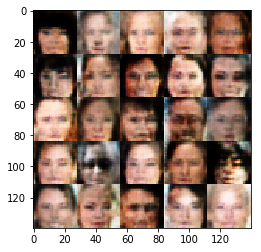

Epoch 1/1... Discriminator Loss: 0.6330... Generator Loss: 1.6604
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.5294
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 0.7363... Generator Loss: 1.2678
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.3451
Epoch 1/1... Discriminator Loss: 1.7984... Generator Loss: 0.3011
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.7617


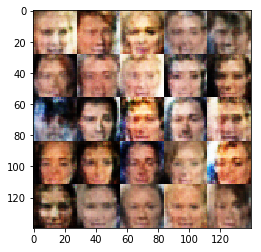

Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 1.9147
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.8615
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 2.9900
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 1.7265
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 3.4272
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 2.9345
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 2.2408
Epoch 1/1... Discriminator Loss: 1.7488... Generator Loss: 2.3160
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 2.3424


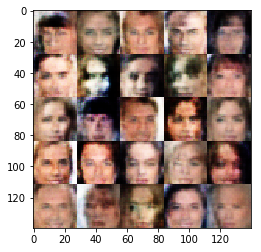

Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 2.5657
Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 1.7577
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 1.7950
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 2.4332
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 2.4607
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.7361


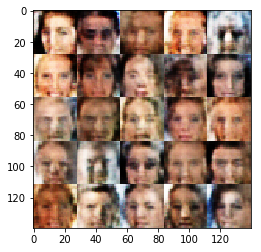

Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.8144
Epoch 1/1... Discriminator Loss: 0.7861... Generator Loss: 2.0486
Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 1.9890
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.5174
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.4382
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.5016
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 2.8982


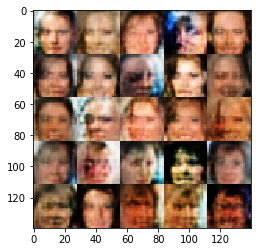

Epoch 1/1... Discriminator Loss: 1.8894... Generator Loss: 0.2793
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 3.3423
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 2.6733
Epoch 1/1... Discriminator Loss: 0.7143... Generator Loss: 3.0770
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.8412
Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 2.0572
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.4625


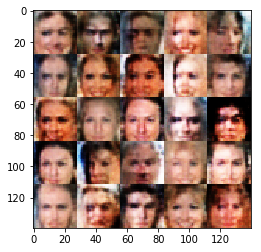

Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 1.3953
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.7866... Generator Loss: 0.3172
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 2.2667
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 1.2844
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 2.0436
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 1.2982
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 1.7607


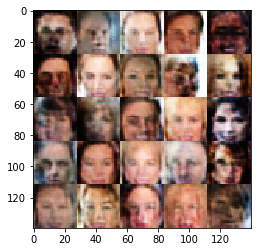

Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.4298
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.3773
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 2.6067
Epoch 1/1... Discriminator Loss: 0.6462... Generator Loss: 1.5858


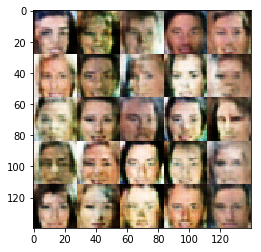

Epoch 1/1... Discriminator Loss: 1.9709... Generator Loss: 0.2479
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.4823
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.3229
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.6143


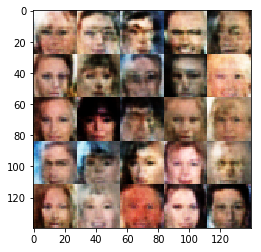

Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.5748
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 1.4551
Epoch 1/1... Discriminator Loss: 0.8182... Generator Loss: 1.1519
Epoch 1/1... Discriminator Loss: 2.6526... Generator Loss: 0.1145
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 1.6439
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 1.6656
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 1.6629
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 1.3733


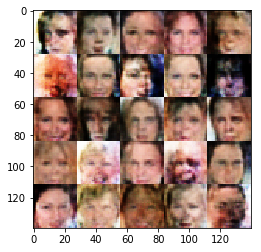

Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 2.0794
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 1.3877
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 2.1653
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.8121


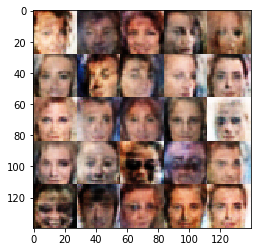

Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.9208
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 2.6705
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 2.0974
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.4962


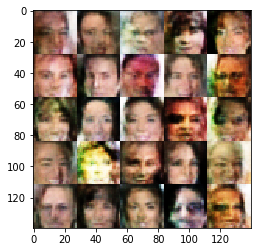

Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 2.2329
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 0.7073... Generator Loss: 1.7891
Epoch 1/1... Discriminator Loss: 0.7670... Generator Loss: 1.4270
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.5496
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 1.7987
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 1.2995


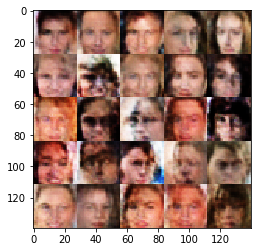

Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.4436
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.1225
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.4605
Epoch 1/1... Discriminator Loss: 0.5543... Generator Loss: 2.4216


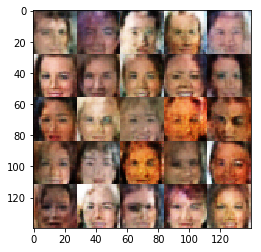

Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 1.7157
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.4393
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.1454
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 2.0655
Epoch 1/1... Discriminator Loss: 0.6334... Generator Loss: 1.6096
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 1.7980
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 1.1099
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.6579


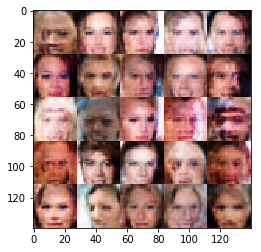

Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.3846
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.4055
Epoch 1/1... Discriminator Loss: 1.6307... Generator Loss: 0.3722
Epoch 1/1... Discriminator Loss: 1.9329... Generator Loss: 0.2832
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.7040
Epoch 1/1... Discriminator Loss: 1.6783... Generator Loss: 0.3439


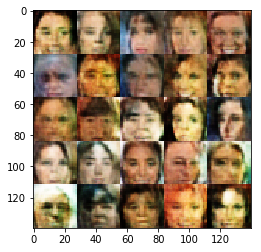

Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 1.8721
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.6544
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 1.6842
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.4650
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.6093
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.3601


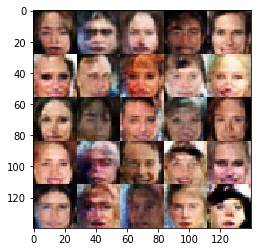

Epoch 1/1... Discriminator Loss: 2.4737... Generator Loss: 0.1481
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 2.3004
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.3308
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 1.9969
Epoch 1/1... Discriminator Loss: 0.6794... Generator Loss: 1.4590
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.3239
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.8501


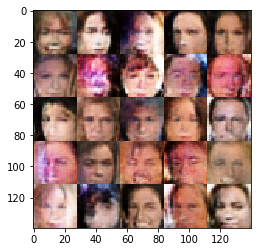

Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.4225
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 0.6545... Generator Loss: 1.5552
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.7113... Generator Loss: 0.3425
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.6694
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 1.7279
Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 1.1306


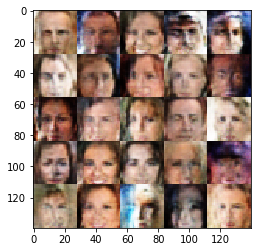

Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.6596
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.9807
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 2.2522
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 1.8234
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.7536... Generator Loss: 0.3467
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 1.8105


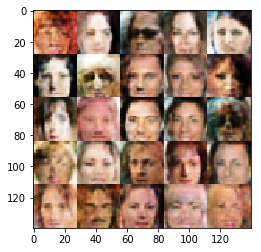

Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 1.8683
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 1.9596
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.7493


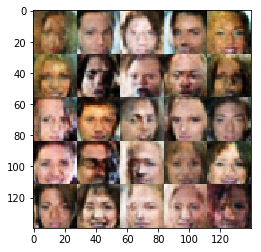

Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 1.7995
Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 1.6113
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.3116
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.4419


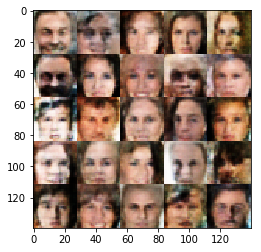

Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.5473
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.4508
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 1.4225
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.6435


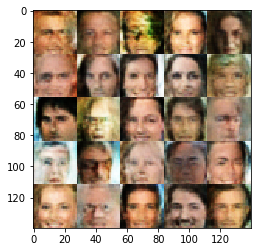

Epoch 1/1... Discriminator Loss: 1.5974... Generator Loss: 0.3606
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 1.7282... Generator Loss: 0.4223
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.6904... Generator Loss: 0.3587
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.7376
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.6995


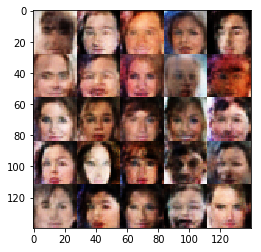

Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 0.8233... Generator Loss: 1.9276
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.6541... Generator Loss: 0.3497
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.3512
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.5037


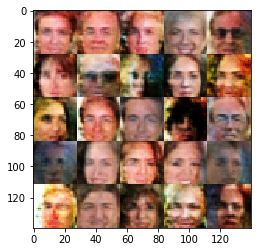

Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.4287
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.6076


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.